In [26]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import yaml
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from JOPLEn.enums import NormType, CellModel
from JOPLEn.singletask import l21_norm, linf1_norm
from JOPLEn.singletask import JOPLEn
from JOPLEn.partitioner import VPartition
from pyHSICLasso import HSICLasso
from sklearn.kernel_ridge import KernelRidge
from ccm import ccm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance


import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from ax.service.ax_client import AxClient, ObjectiveProperties

import warnings
import logging
from ax.utils.common.logger import ROOT_STREAM_HANDLER

ROOT_STREAM_HANDLER.setLevel(logging.ERROR)
from collections import defaultdict
from sklearn.pipeline import Pipeline


# Hide future warnings because ax uses deprecated functions from pandas
warnings.simplefilter(action="ignore", category=FutureWarning)
# Hide unfixable warning from ax (warns about default behavior but there isn't
# a clear way to turn the warning off)
warnings.simplefilter(action="ignore", category=UserWarning)


LST_DATASETS = ["boston", "diabetes", "riboflavin"]

CACHE_DIR = Path("ax_runs") / "st_selection"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
DS_PATH = Path("..") / "datasets"

PARAM_PATH = Path(".") / "parameters"
PLOT_PATH = Path(".") / "plots"


In [27]:
model_info = {}

for file in PARAM_PATH.glob("*.yaml"):
    model_info[file.stem] = yaml.safe_load(open(file, "r"))


In [28]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def train_sklearn(
    ModelClass,
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
):
    model = Pipeline([("scaler", StandardScaler()), ("model", ModelClass(**params))])
    model.fit(x_train, y_train.flatten())

    return model


def train_if_sel_feats(sel_feats, x_train, y_train, x_val, y_val, x_test, y_test):
    if sel_feats.sum() > 0:
        pred_model = GradientBoostingRegressor(random_state=0)
        pred_model.fit(x_train[:, sel_feats], y_train.flatten())

        y_train_pred = pred_model.predict(x_train[:, sel_feats])
        y_val_pred = pred_model.predict(x_val[:, sel_feats])
        y_test_pred = pred_model.predict(x_test[:, sel_feats])

    else:
        pred_model = None
        y_train_pred = np.ones_like(y_train) * y_train.mean()
        y_val_pred = np.ones_like(y_val) * y_train.mean()
        y_test_pred = np.ones_like(y_test) * y_train.mean()

    return {
        "train_error": float(rmse(y_train.flatten(), y_train_pred)),
        "val_error": float(rmse(y_val.flatten(), y_val_pred)),
        "test_error": float(rmse(y_test.flatten(), y_test_pred)),
    }, pred_model


def train_lasso(params, x_train, y_train, x_val, y_val, x_test, y_test):
    pipeline = train_sklearn(
        Lasso,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    eps = 1e-6

    sel_model = pipeline.named_steps["model"]

    sel_feats = np.abs(sel_model.coef_) > eps

    res, pred_model = train_if_sel_feats(
        sel_feats,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    return {
        "density": float(sel_feats.mean()),
        **res,
        "model": (sel_model, pred_model),
    }


def dummy_regressor(x_train, y_train, x_val, y_val, x_test, y_test):
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(x_train, y_train.flatten())

    return {
        "train_error": float(rmse(y_train.flatten(), dummy.predict(x_train))),
        "val_error": float(rmse(y_val.flatten(), dummy.predict(x_val))),
        "test_error": float(rmse(y_test.flatten(), dummy.predict(x_test))),
    }


def train_joplen(
    params,
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
):
    params = deepcopy(params)

    initial_params = {
        "partitioner": eval(params.pop("partitioner")),
        "n_cells": params.pop("n_cells"),
        "n_partitions": params.pop("n_partitions"),
        "random_state": params.pop("random_state"),
    }

    initial_params["cell_model"] = eval(params.pop("cell_model"))
    assert initial_params["cell_model"] == CellModel.linear

    sel_model = JOPLEn(**initial_params)

    assert "norm_type" in params

    params["norm_type"] = eval(params["norm_type"])

    history = sel_model.fit(
        x_train,
        y_train,
        val_x=x_val,
        val_y=y_val,
        **params,
    )

    if params["norm_type"] == NormType.L21:
        norm = l21_norm
    elif params["norm_type"] == NormType.LINF1:
        norm = linf1_norm
    else:
        raise NotImplementedError()

    # ignore bias term
    sel_features = (norm(sel_model.w).get() > 1e-6)[:-1]

    res, pred_model = train_if_sel_feats(
        sel_features,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    return {
        **res,
        "model": (sel_model, pred_model),
        "epochs": len(history),
        "density": float(sel_features.mean()),
    }


def normalize(x_train, x_val, x_test):
    ss = StandardScaler()

    x_train = ss.fit_transform(x_train)
    x_val = ss.transform(x_val)
    x_test = ss.transform(x_test)

    return x_train, x_val, x_test


def train_hsic(params, x_train, y_train, x_val, y_val, x_test, y_test, density):
    params = deepcopy(params)

    n_features = int(np.ceil(x_train.shape[1] * density))

    assert n_features > 0, "n_features must be > 0"

    x_train, x_val, x_test = normalize(x_train, x_val, x_test)

    sel_model = HSICLasso()
    sel_model.input(x_train, y_train)
    sel_model.regression(
        n_features,
        max_neighbors=params.pop("max_neighbors"),
        B=params.pop("B"),
        M=params.pop("M"),
    )

    sel_features = sel_model.get_index()

    pred_model = KernelRidge(**params)
    pred_model.fit(x_train[:, sel_features], y_train)

    return {
        "train_error": float(
            rmse(y_train, pred_model.predict(x_train[:, sel_features]))
        ),
        "val_error": float(rmse(y_val, pred_model.predict(x_val[:, sel_features]))),
        "test_error": float(rmse(y_test, pred_model.predict(x_test[:, sel_features]))),
        "model": (sel_model, pred_model),
        "density": float(n_features / x_train.shape[1]),
    }


def train_ccm(params, x_train, y_train, x_val, y_val, x_test, y_test, density):
    params = deepcopy(params)

    n_features = int(np.ceil(x_train.shape[1] * density))

    assert n_features > 0, "n_features must be > 0"

    x_train, x_val, x_test = normalize(x_train, x_val, x_test)

    feature_idx = ccm.ccm(
        x_train,
        y_train,
        n_features,
        epsilon=params["epsilon"],  # use for both
        type_Y=params.pop("type_Y"),
        iterations=params.pop("iterations"),
        verbose=params.pop("verbose"),
        learning_rate=params.pop("learning_rate"),
    )

    sel_features = np.argsort(feature_idx)[:n_features]

    pred_model = SVR(**params)
    pred_model.fit(x_train[:, sel_features], y_train)

    return {
        "train_error": float(
            rmse(y_train, pred_model.predict(x_train[:, sel_features]))
        ),
        "val_error": float(rmse(y_val, pred_model.predict(x_val[:, sel_features]))),
        "test_error": float(rmse(y_test, pred_model.predict(x_test[:, sel_features]))),
        "model": pred_model,
        "density": float(n_features / x_train.shape[1]),
    }


def train_ensemble(
    ModelClass, params, x_train, y_train, x_val, y_val, x_test, y_test, density
):
    params = deepcopy(params)

    n_features = int(np.ceil(x_train.shape[1] * density))

    assert n_features > 0, "n_features must be > 0"

    x_train, x_val, x_test = normalize(x_train, x_val, x_test)

    # select features with highest feature importance
    model = ModelClass(**params)
    model.fit(x_train, y_train)

    # TODO: Should use this method, but it takes way too long (an hour without
    # finishing one round of all three datasets)
    # result = permutation_importance(
    #     model,
    #     x_train,
    #     y_train,
    #     n_repeats=5,
    #     random_state=0,
    # )
    # sel_features = np.argsort(result.importances_mean)[-n_features:]

    # Using this method for now
    sel_features = np.argsort(model.feature_importances_)[-n_features:]

    pred_model = GradientBoostingRegressor(random_state=0)
    pred_model.fit(x_train[:, sel_features], y_train)

    y_train_pred = pred_model.predict(x_train[:, sel_features])
    y_val_pred = pred_model.predict(x_val[:, sel_features])
    y_test_pred = pred_model.predict(x_test[:, sel_features])

    return {
        "train_error": float(rmse(y_train, y_train_pred)),
        "val_error": float(rmse(y_val, y_val_pred)),
        "test_error": float(rmse(y_test, y_test_pred)),
        "model": pred_model,
        "density": float(n_features / x_train.shape[1]),
    }


def train_rf(params, x_train, y_train, x_val, y_val, x_test, y_test, density):
    return train_ensemble(
        RandomForestRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        density,
    )


def train_gb(params, x_train, y_train, x_val, y_val, x_test, y_test, density):
    return train_ensemble(
        GradientBoostingRegressor,
        params,
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        density,
    )


In [29]:
def pareto_front(
    score: np.ndarray, density: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    unique_density = np.unique(density)

    pareto_score = []
    pareto_density = []

    for d in unique_density:
        mask = density == d
        pareto_score.append(np.min(score[mask]))
        pareto_density.append(d)

    pareto_score = np.array(pareto_score)
    pareto_density = np.array(pareto_density)

    args = np.argsort(pareto_density)

    return pareto_density[args], pareto_score[args]


def score(dummy_res, model_res, alpha):
    res = {
        "norm_error": {
            "train": float(model_res["train_error"] / dummy_res["train_error"]),
            "val": float(model_res["val_error"] / dummy_res["val_error"]),
            "test": float(model_res["test_error"] / dummy_res["test_error"]),
        },
    }

    res["pareto"] = {
        "train": float(
            alpha * model_res["density"] + (1 - alpha) * res["norm_error"]["train"]
        ),
        "val": float(
            alpha * model_res["density"] + (1 - alpha) * res["norm_error"]["val"]
        ),
        "test": float(
            alpha * model_res["density"] + (1 - alpha) * res["norm_error"]["test"]
        ),
    }

    return res


#### Methods that don't explicitly choose numbers of features

In [30]:
train_fn = {
    Lasso.__name__: train_lasso,
    JOPLEn.__name__: train_joplen,
    HSICLasso.__name__: train_hsic,
    ccm.__name__.split(".")[-1]: train_ccm,
    RandomForestRegressor.__name__: train_rf,
    GradientBoostingRegressor.__name__: train_gb,
}


def optimize_model(
    model_info,
    ds_path,
    n_trials,
    minimize,
    loss_type,
    alpha,
    alpha_idx,
):
    ds_name = ds_path.parent.name
    params = model_info["parameters"]

    dir_path = CACHE_DIR / model_info["dir_name"] / ds_name
    exp_path = dir_path / f"experiment_{alpha_idx}.json"
    metadata_path = dir_path / f"metadata_{alpha_idx}.yaml"

    if metadata_path.exists():
        with open(metadata_path, "r") as f:
            metadata = yaml.load(f, Loader=yaml.FullLoader)
        return metadata

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    dummy_res = dummy_regressor(
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    if not exp_path.exists():
        ax_client = AxClient(
            random_seed=0,
            verbose_logging=False,
        )

        ax_client.create_experiment(
            name=model_info["model"],
            parameters=params,
            objectives={loss_type: ObjectiveProperties(minimize=minimize)},
            overwrite_existing_experiment=True,
        )

        for _ in range(n_trials):
            round_params, trial_index = ax_client.get_next_trial()

            try:
                model_res = train_fn[model_info["model"]](
                    round_params,
                    x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val,
                    x_test=x_test,
                    y_test=y_test,
                )
                model_score = score(dummy_res, model_res, alpha)
                ax_client.complete_trial(
                    trial_index=trial_index, raw_data=model_score["pareto"]["val"]
                )
            except ValueError as e:
                print(e)
                ax_client.abandon_trial(
                    trial_index=trial_index,
                    reason=str(e),
                )
    else:
        ax_client = AxClient.load_from_json_file(exp_path)

    exp_path.parent.mkdir(parents=True, exist_ok=True)

    ax_client.save_to_json_file(
        filepath=exp_path,
    )

    best_parameters, _ = ax_client.get_best_parameters()

    model_res = train_fn[model_info["model"]](
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
    )
    model_score = score(dummy_res, model_res, alpha)

    model_res.pop("model", None)

    metadata = {
        "alpha": float(alpha),
        "model": {
            "name": model_info["model"],
            "results": model_res,
            "score": model_score,
        },
        "dummy": {
            "name": "DummyRegressor",
            **dummy_res,
        },
    }

    with open(metadata_path, "w") as f:
        yaml.dump(metadata, f)

    return metadata


In [31]:
n_samples = 11
alphas = np.linspace(0, 1, n_samples, endpoint=True)
datasets = [DS_PATH / ds / "processed" for ds in LST_DATASETS]


In [33]:
reg_res = defaultdict(lambda: defaultdict(list))
itr = tqdm(alphas)

for i, alpha in enumerate(itr):
    for ds_path in datasets:
        for file_name, info in model_info.items():
            if "st_selection" not in info["experiments"]:
                continue
            if info["selection_type"] != "penalty":
                continue

            ds_name = ds_path.parent.name

            # Not necessary for now, only slows things down
            if file_name == "joplen_linear_inf":
                continue

            model_str = f"{file_name} on {ds_name}"
            itr.set_description(f"Running {model_str : <50}")
            res = optimize_model(
                info, ds_path, 50, True, "rmse", alpha, f"{i}_{n_samples}"
            )

            if res is not None:
                reg_res[info["name"]][ds_name].append(res)

pen_reg_res = {k: dict(v) for k, v in reg_res.items()}


Running lasso on diabetes                                 :  36%|███▋      | 4/11 [25:33<44:45, 383.62s/it]/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
Running lasso on riboflavin                               :  36%|███▋      | 4/11 [29:20<44:45, 383.62s/it]/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Opt

---

#### Methods that explicitly chose numbers of features

In [35]:
def optimize_model(
    model_info,
    ds_path,
    n_trials,
    minimize,
    loss_type,
    alpha,
    alpha_idx,
):
    ds_name = ds_path.parent.name
    params = model_info["parameters"]

    dir_path = CACHE_DIR / model_info["dir_name"] / ds_name
    exp_path = dir_path / f"experiment_{alpha_idx}.json"
    metadata_path = dir_path / f"metadata_{alpha_idx}.yaml"

    if metadata_path.exists():
        with open(metadata_path, "r") as f:
            metadata = yaml.load(f, Loader=yaml.FullLoader)
        return metadata

    x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
    x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
    x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
    y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
    y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
    y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

    dummy_res = dummy_regressor(
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
    )

    if not exp_path.exists():
        ax_client = AxClient(
            random_seed=0,
            verbose_logging=False,
        )

        ax_client.create_experiment(
            name=model_info["model"],
            parameters=params,
            objectives={loss_type: ObjectiveProperties(minimize=minimize)},
            overwrite_existing_experiment=True,
        )

        for _ in range(n_trials):
            round_params, trial_index = ax_client.get_next_trial()

            try:
                model_res = train_fn[model_info["model"]](
                    round_params,
                    x_train=x_train,
                    y_train=y_train,
                    x_val=x_val,
                    y_val=y_val,
                    x_test=x_test,
                    y_test=y_test,
                    density=1 - alpha,
                )
                model_score = score(dummy_res, model_res, alpha)
                ax_client.complete_trial(
                    trial_index=trial_index, raw_data=model_score["norm_error"]["val"]
                )
            except ValueError as e:
                print(e)
                ax_client.abandon_trial(
                    trial_index=trial_index,
                    reason=str(e),
                )
    else:
        ax_client = AxClient.load_from_json_file(exp_path)

    exp_path.parent.mkdir(parents=True, exist_ok=True)

    ax_client.save_to_json_file(
        filepath=exp_path,
    )

    best_parameters, _ = ax_client.get_best_parameters()

    model_res = train_fn[model_info["model"]](
        best_parameters,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        x_test=x_test,
        y_test=y_test,
        density=1 - alpha,
    )

    model_score = score(dummy_res, model_res, alpha)

    model_res.pop("model", None)

    metadata = {
        "alpha": float(alpha),
        "model": {
            "name": model_info["model"],
            "results": model_res,
            "score": model_score,
        },
        "dummy": {
            "name": "DummyRegressor",
            **dummy_res,
        },
    }

    with open(metadata_path, "w") as f:
        yaml.dump(metadata, f)

    return metadata


In [36]:
reg_res = defaultdict(lambda: defaultdict(list))

datasets = [DS_PATH / ds / "processed" for ds in LST_DATASETS]
itr = tqdm(alphas[:-1])

for i, alpha in enumerate(itr):
    for ds_path in datasets:
        for file_name, info in model_info.items():
            if "st_selection" not in info["experiments"]:
                continue
            if info["selection_type"] != "num_feats":
                continue

            # # Skipping for now because CCM is too slow
            if info["model"] in [HSICLasso.__name__, ccm.__name__]:
                continue

            ds_name = ds_path.parent.name

            model_str = f"{file_name} on {ds_name}"
            itr.set_description(f"Running {model_str : <50}")
            res = optimize_model(
                info, ds_path, 50, True, "rmse", alpha, f"{i}_{n_samples}"
            )

            if res is not None:
                reg_res[info["name"]][ds_name].append(res)

feat_reg_res = {k: dict(v) for k, v in reg_res.items()}


Running rf on riboflavin                                  :   0%|          | 0/10 [04:53<?, ?it/s]/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
Running gb on riboflavin                                  :   0%|          | 0/10 [07:41<?, ?it/s]/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/matt/code/school/joplen/code/joplen-tests/my_env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 t

In [40]:
joined_res.keys()


dict_keys(['JOPLEn (linear mu)', 'LASSO', 'Random forest', 'CCM', 'Gradient Boosting'])

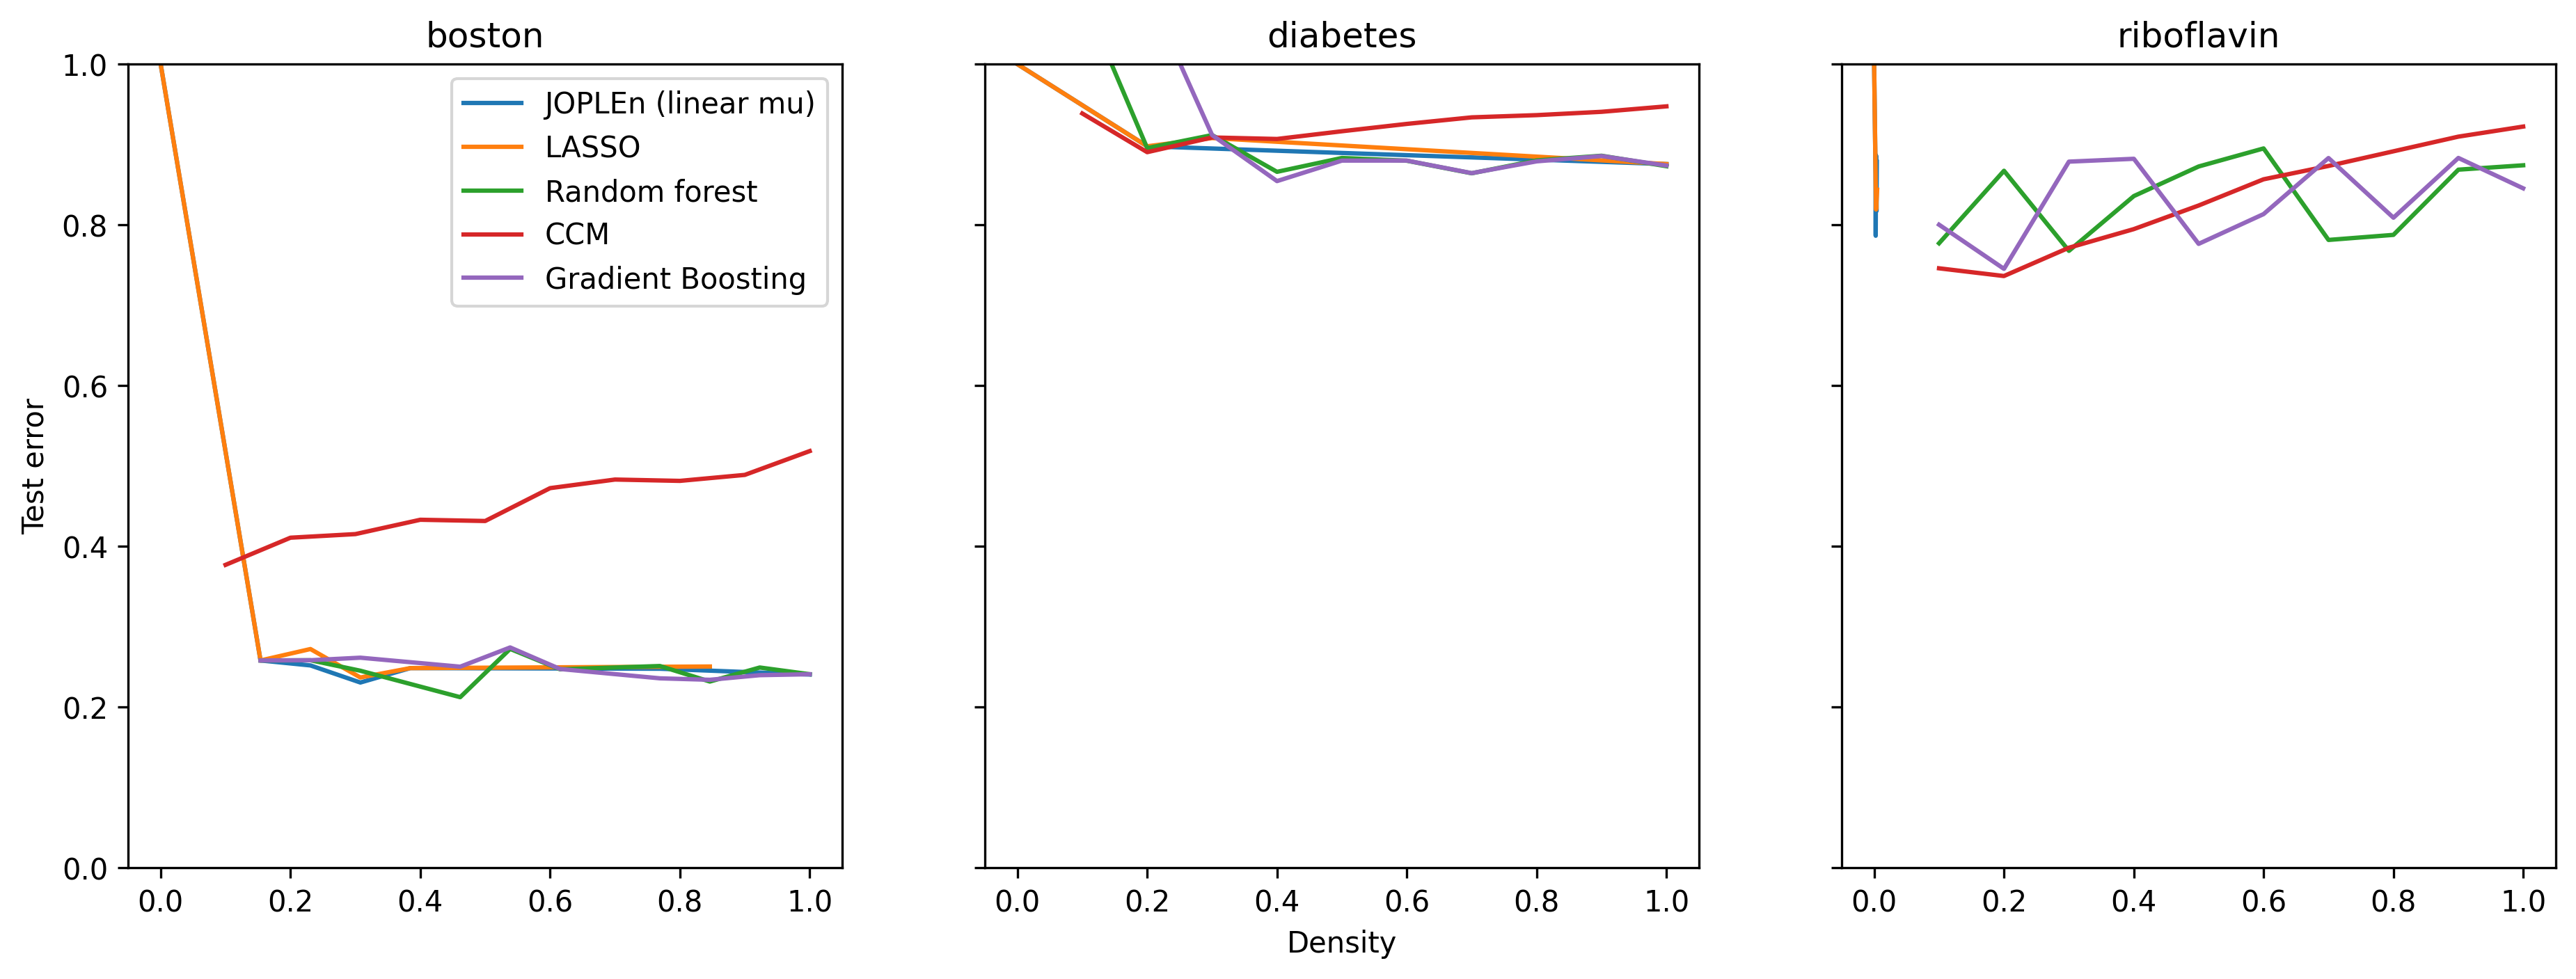

In [42]:
n_ds = len(LST_DATASETS)

joined_res = {
    **pen_reg_res,
    **feat_reg_res,
}

fig, axs = plt.subplots(1, n_ds, figsize=(5 * n_ds, 5), sharey=True, dpi=300)

for ax, ds in zip(axs, LST_DATASETS):
    for k in joined_res:
        ds_res = joined_res[k][ds]
        model_score = np.array(
            [v["model"]["score"]["norm_error"]["test"] for v in ds_res]
        )
        model_density = np.array([v["model"]["results"]["density"] for v in ds_res])

        front_density, front_score = pareto_front(model_score, model_density)

        ax.plot(front_density, front_score, label=k)

    ax.set_title(ds)

axs[0].legend()

axs[1].set_xlabel("Density")
axs[0].set_ylabel("Test error")

axs[0].set_ylim(0, 1)

plt.show()


In [11]:
ds_path = DS_PATH / "boston" / "processed"

x_train = np.loadtxt(ds_path / "x_train.csv", delimiter=",")
x_val = np.loadtxt(ds_path / "x_val.csv", delimiter=",")
x_test = np.loadtxt(ds_path / "x_test.csv", delimiter=",")
y_train = np.loadtxt(ds_path / "y_train.csv", delimiter=",")
y_val = np.loadtxt(ds_path / "y_val.csv", delimiter=",")
y_test = np.loadtxt(ds_path / "y_test.csv", delimiter=",")

# model = RandomForestRegressor(n_estimators=100, random_state=0)
# model.fit(x_train, y_train)
# print(model.score(x_test, y_test))

# best_feature = model.feature_importances_.argmax()

# x_train = x_train[:, best_feature].reshape(-1, 1)
# x_val = x_val[:, best_feature].reshape(-1, 1)
# x_test = x_test[:, best_feature].reshape(-1, 1)

# model.fit(x_train, y_train)
# print(model.score(x_test, y_test))


In [15]:
x_train.shape[1] * 0.09999999999999998


1.2999999999999998

5

##### Notes

The methods that perform much better all have refitting after the feature selection.
Maybe I should do the same thing with JOPLEn and LASSO.
It could be that the feature penalty is significantly impacting performance because of things like shrinkage.